In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(14,8),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
from matplotlib.ticker import PercentFormatter
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import plotly.express as px
from datetime import datetime, date, time, timedelta

from scipy.stats.mstats import winsorize

In [2]:
def renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] > 0]

def not_renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] == 0]

def old(dataframe, yr= 1945):
    return dataframe[dataframe["yr_built"] < yr]

def new(dataframe, yr=1945):
    return dataframe[dataframe["yr_built"] >= yr]

def water(dataframe):
    return dataframe[dataframe["waterfront"] == 1]

def binby(dataframe, column, bins=5, lab = True):
    nbins = bins
    bin_borders = np.arange(dataframe[column].min()*(1-nbins/100), dataframe[column].max()*(1+nbins/100), (dataframe[column].max()-dataframe[column].min())/nbins)
    if lab == False:
        binned_column = pd.cut(dataframe[column], bins= bin_borders, labels = lab)
    else:
        binned_column = pd.cut(dataframe[column], bins= bin_borders, labels = bin_borders[:-1])
    binned_column.name = column+"_bin"
    return pd.concat([dataframe, binned_column], axis=1)

# Load

In [3]:
df= pd.read_csv("data/King_County_House_prices_dataset.csv")
df.yr_renovated = df["yr_renovated"].fillna(-1)
df.head()

id        date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014 221900.000         3      1.000         1180   
1  6414100192   12/9/2014 538000.000         3      2.250         2570   
2  5631500400   2/25/2015 180000.000         2      1.000          770   
3  2487200875   12/9/2014 604000.000         4      3.000         1960   
4  1954400510   2/18/2015 510000.000         3      2.000         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650   1.000         NaN 0.000  ...      7        1180            0.0   
1      7242   2.000       0.000 0.000  ...      7        2170          400.0   
2     10000   1.000       0.000 0.000  ...      6         770            0.0   
3      5000   1.000       0.000 0.000  ...      7        1050          910.0   
4      8080   1.000       0.000 0.000  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  
0     1955         0.000    98178 47.511 -122.257           1340        5650  
1     1951      1991.000    98125 47.721 -122.319           1690        7639  
2     1933        -1.000    98028 47.738 -122.233           2720        8062  
3     1965         0.000    98136 47.521 -122.393           1360        5000  
4     1987         0.000    98074 47.617 -122.045           1800        7503  

[5 rows x 21 columns]

In [4]:
df.date = pd.to_datetime(df.date)
df["month"] = df.date.dt.month

In [5]:
df = binby(df, "price", 10)
df = binby(df, "sqft_living", 5)
df = binby(df, "yr_built", 5)

In [59]:
df["price_of_same_size_and_loc"] = df.groupby(["zipcode","sqft_living_bin", "yr_built"])["price"].transform("mean")
df["neighborhood_price_win"] = df.groupby("zipcode")["price"].transform(lambda x: np.mean(winsorize(x, limits=[0,0.01], inclusive= (True, True))))
df["relative_price_win"] = (df["price"]-df["neighborhood_price_win"]) / df["neighborhood_price_win"]
df["relative_price_bin"] = (df["price"]-df["price_of_same_size_and_loc"]) / df["price_of_same_size_and_loc"]
df["relative_price_bin2"] = ((df["price"]/ df["price_of_same_size_and_loc"]) -1)*100

In [7]:
df["relative_size"] = df.sqft_living / df.sqft_living15

In [8]:
df.shape

(21597, 30)

In [9]:
def renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] > 0]

def not_renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] == 0]

renovated_houses = renovated(df)
renovated_houses["yr_since_reno"] = 2015- df.yr_renovated
#renovated_houses["renovated"] = "renovated"
not_renovated = not_renovated(df)
not_renovated["yr_since_reno"]= 2015 - not_renovated.yr_built
#not_renovated["renovated"] = "not renovated"
unknown_reno = df[df["yr_renovated"]==-1]
unknown_reno["yr_since_reno"] = np.nan
#unknown_reno["renovated"] = np.nan
df = pd.concat([renovated_houses, not_renovated, unknown_reno], axis = 0)
df.shape

(21597, 31)

In [10]:
def renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] > 0]

def not_renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] == 0]

recently = renovated(df[df["yr_since_reno"]<=10])
recently["renovated"] = "recently"
non_recent = renovated(df[df["yr_since_reno"]>10])
non_recent["renovated"] = "not_recent"
never_renovated = not_renovated(df)
never_renovated["renovated"] = "never"
unknown_reno["renovated"] = np.nan
df = pd.concat([recently, non_recent, never_renovated, unknown_reno], axis = 0).sort_index()
df.shape

(21597, 32)

In [11]:
bin_borders = np.arange(0, 121, 10)
binned_column = pd.cut(df["yr_since_reno"], bins= bin_borders, labels = bin_borders[:-1])
binned_column.name = "yr_since_reno_bin"
df =  pd.concat([df, binned_column], axis=1)

In [12]:
historicals =  old(df)
historicals["age"] = "historical"
moderns =  new(df)
moderns["age"] = "modern"
df= pd.concat([historicals, moderns]).sort_index()


Plots to show:
barplot: relative market price of old houses, divided by years since renovation

Recommendations:

look there for old houses
best to buy/sell old houses with size = x or higher/smaller
renovate if has been more than x years, because renovation is more valuable in old houses?
or: don't renovate: because houses in original state are worth more (if condition is good)

Text(0.5, 1.0, 'Years since renovation')

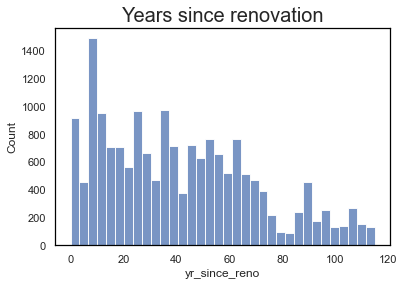

In [13]:
sns.histplot(data= df, x="yr_since_reno").set_title('Years since renovation', fontsize=20)

Plots to show:
barplot: relative market price of old houses, divided by years since renovation

Recommendations:

look there for old houses  
best to buy/sell old houses with size = x or higher/smaller  
renovate if has been more than x years, because renovation is more valuable in old houses?  
or: don't renovate: because houses in original state are worth more (if condition is good)  

# 1st Plot - Renovating or not?

## Impact of renovation on relative house prices:
recent renovation = 10 years  
historical = built before 1945

In [58]:
df.head()

id       date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13 221900.000         3      1.000         1180   
1  6414100192 2014-12-09 538000.000         3      2.250         2570   
2  5631500400 2015-02-25 180000.000         2      1.000          770   
3  2487200875 2014-12-09 604000.000         4      3.000         1960   
4  1954400510 2015-02-18 510000.000         3      2.000         1680   

   sqft_lot  floors  waterfront  view  ...  relative_size  yr_since_reno  \
0      5650   1.000         NaN 0.000  ...          0.881         60.000   
1      7242   2.000       0.000 0.000  ...          1.521         24.000   
2     10000   1.000       0.000 0.000  ...          0.283            NaN   
3      5000   1.000       0.000 0.000  ...          1.441         50.000   
4      8080   1.000       0.000 0.000  ...          0.933         28.000   

    renovated yr_since_reno_bin         age  big_sales_per_month  \
0       never                50      modern                  NaN   
1  not_recent                20      modern              525.000   
2         NaN               NaN  historical                  NaN   
3       never                40      modern              525.000   
4       never                20      modern                  NaN   

   bad_sales_per_month  monthly_sales  monthly sales  relative_price_bin2  
0              764.000           1876           1876               -0.273  
1                  NaN           1470           1470                0.388  
2              108.000           1247           1247               -0.180  
3                  NaN           1470           1470                0.184  
4              481.000           1247           1247               -0.113  

[5 rows x 39 columns]

In [15]:
#sns.barplot(data= renovated(df), x="yr_since_reno_bin", y="relative_price_win", hue="age", palette = "pastel", ci= None, hue_order=["historical", "modern"])
#plt.xlim(-0.5,4.5)
#plt.ylim(-0.2,0.4)
#plt.axhline(0, alpha=0.5)


In [16]:
#sns.barplot(data= renovated(df), x="yr_since_reno_bin", y="relative_price_bin", hue="age", palette = "pastel", ci= None, hue_order=["historical", "modern"])
#plt.xlim(-0.5,4.5)
#plt.ylim(-0.2,0.15)
#plt.axhline(0, alpha=0.5)


In [17]:
#sns.barplot(data= df, x="age", y="relative_price_win", hue="renovated", palette = "pastel", order=["historical", "modern"], hue_order=["recently","not_recent","never"], ci= None)
#plt.axhline(0, alpha=0.5)

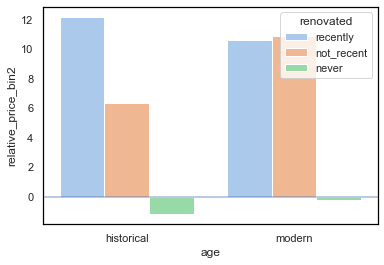

In [60]:
sns.barplot(data= df, x="age", y="relative_price_bin2", hue="renovated", palette = "pastel", order=["historical", "modern"], hue_order=["recently","not_recent","never"], ci= None)
plt.axhline(0, alpha=0.5)

In [61]:
#sns.barplot(data=df, x="condition", y="relative_price_win", hue="age", palette = "pastel", ci= None, hue_order=["historical", "modern"])
#plt.axhline(0, alpha=0.5)

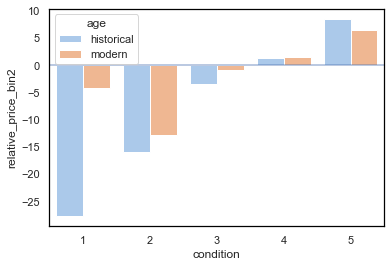

In [62]:
sns.barplot(data=df, x="condition", y="relative_price_bin2", hue="age", palette = "pastel", ci= None, hue_order=["historical", "modern"])
plt.axhline(0, alpha=0.5)

In [21]:
#sns.barplot(data=df, x="condition", y="relative_price_win", hue="renovated", palette = "pastel", ci= None, hue_order=["recently","not_recent","never"])
#plt.axhline(0, alpha=0.5)

In [22]:
#sns.barplot(data=old(df), x="condition", y="relative_price_bin", hue="renovated", palette = "pastel", ci= None, hue_order=["recently","not_recent","never"])
#plt.axhline(0, alpha=0.5)

# 2nd Plot - What month?

<AxesSubplot:xlabel='month', ylabel='relative_price_bin2'>

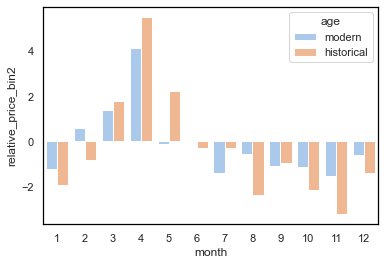

In [63]:
sns.barplot(data= df, x="month", y="relative_price_bin2", hue="age", ci=None, palette="pastel")

<AxesSubplot:xlabel='month', ylabel='relative_price_bin2'>

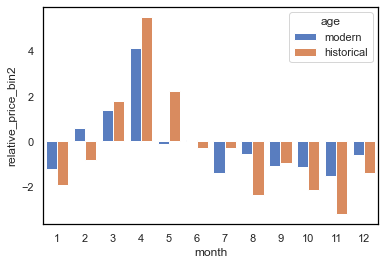

In [64]:
sns.barplot(data= df, x="month", y="relative_price_bin2", hue="age", ci=None, palette="muted")

In [25]:
def old(dataframe, yr= 1945):
    return dataframe[dataframe["yr_built"] < yr]

def new(dataframe, yr=1945):
    return dataframe[dataframe["yr_built"] >= yr]



In [52]:
olds= old(df)
olds["big_sales_per_month"] = olds[olds["relative_price_bin2"]>0].groupby("month")["id"].transform("count")
news= new(df)
news["big_sales_per_month"] = news[news["relative_price_bin2"]>0].groupby("month")["id"].transform("count")
df = pd.concat([olds, news], axis = 0).sort_index()

olds= old(df)
olds["bad_sales_per_month"] = olds[olds["relative_price_bin2"]<0].groupby("month")["id"].transform("count")
news= new(df)
news["bad_sales_per_month"] = news[news["relative_price_bin2"]<0].groupby("month")["id"].transform("count")
df = pd.concat([olds, news], axis = 0).sort_index()
df["monthly_sales"] = df.groupby("month")["id"].transform("count")


<AxesSubplot:xlabel='month', ylabel='big_sales_per_month'>

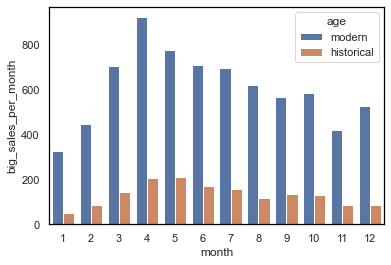

In [65]:
sns.barplot(data= df, x= "month", y="big_sales_per_month", hue="age")

<AxesSubplot:xlabel='month', ylabel='monthly_sales'>

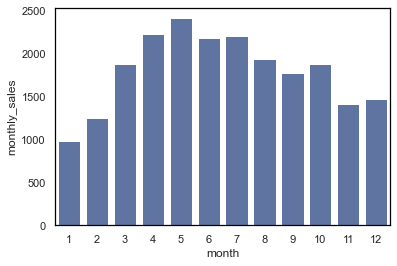

In [66]:
sns.barplot(data= df, x= "month", y="monthly_sales",color="#5f74a0", saturation=1)

In [29]:
df["monthly sales"] = df.groupby("month")["id"].transform("count")
df

id       date      price  bedrooms  bathrooms  sqft_living  \
0      7129300520 2014-10-13 221900.000         3      1.000         1180   
1      6414100192 2014-12-09 538000.000         3      2.250         2570   
2      5631500400 2015-02-25 180000.000         2      1.000          770   
3      2487200875 2014-12-09 604000.000         4      3.000         1960   
4      1954400510 2015-02-18 510000.000         3      2.000         1680   
...           ...        ...        ...       ...        ...          ...   
21592   263000018 2014-05-21 360000.000         3      2.500         1530   
21593  6600060120 2015-02-23 400000.000         4      2.500         2310   
21594  1523300141 2014-06-23 402101.000         2      0.750         1020   
21595   291310100 2015-01-16 400000.000         3      2.500         1600   
21596  1523300157 2014-10-15 325000.000         2      0.750         1020   

       sqft_lot  floors  waterfront  view  ...  relative_price_bin  \
0          5650   1.000         NaN 0.000  ...              -0.273   
1          7242   2.000       0.000 0.000  ...               0.388   
2         10000   1.000       0.000 0.000  ...              -0.180   
3          5000   1.000       0.000 0.000  ...               0.184   
4          8080   1.000       0.000 0.000  ...              -0.113   
...         ...     ...         ...   ...  ...                 ...   
21592      1131   3.000       0.000 0.000  ...              -0.287   
21593      5813   2.000       0.000 0.000  ...               0.034   
21594      1350   2.000       0.000 0.000  ...              -0.001   
21595      2388   2.000         NaN 0.000  ...              -0.013   
21596      1076   2.000       0.000 0.000  ...              -0.160   

       relative_size  yr_since_reno   renovated  yr_since_reno_bin  \
0              0.881         60.000       never                 50   
1              1.521         24.000  not_recent                 20   
2              0.283            NaN         NaN                NaN   
3              1.441         50.000       never                 40   
4              0.933         28.000       never                 20   
...              ...            ...         ...                ...   
21592          1.000          6.000       never                  0   
21593          1.262          1.000       never                  0   
21594          1.000          6.000       never                  0   
21595          1.135         11.000       never                 10   
21596          1.000          7.000       never                  0   

              age  big_sales_per_month  bad_sales_per_month  monthly_sales  \
0          modern                  NaN              764.000           1876   
1          modern              525.000                  NaN           1470   
2      historical                  NaN              108.000           1247   
3          modern              525.000                  NaN           1470   
4          modern                  NaN              481.000           1247   
...           ...                  ...                  ...            ...   
21592      modern                  NaN              928.000           2414   
21593      modern              446.000                  NaN           1247   
21594      modern                  NaN              865.000           2178   
21595      modern                  NaN              403.000            978   
21596      modern                  NaN              764.000           1876   

       monthly sales  
0               1876  
1               1470  
2               1247  
3               1470  
4               1247  
...              ...  
21592           2414  
21593           1247  
21594           2178  
21595            978  
21596           1876  

[21597 rows x 38 columns]

# 3rd Plot - Location of Interesting properties
Where are the most lucrative?

To buy: Old houses that have not been renovated

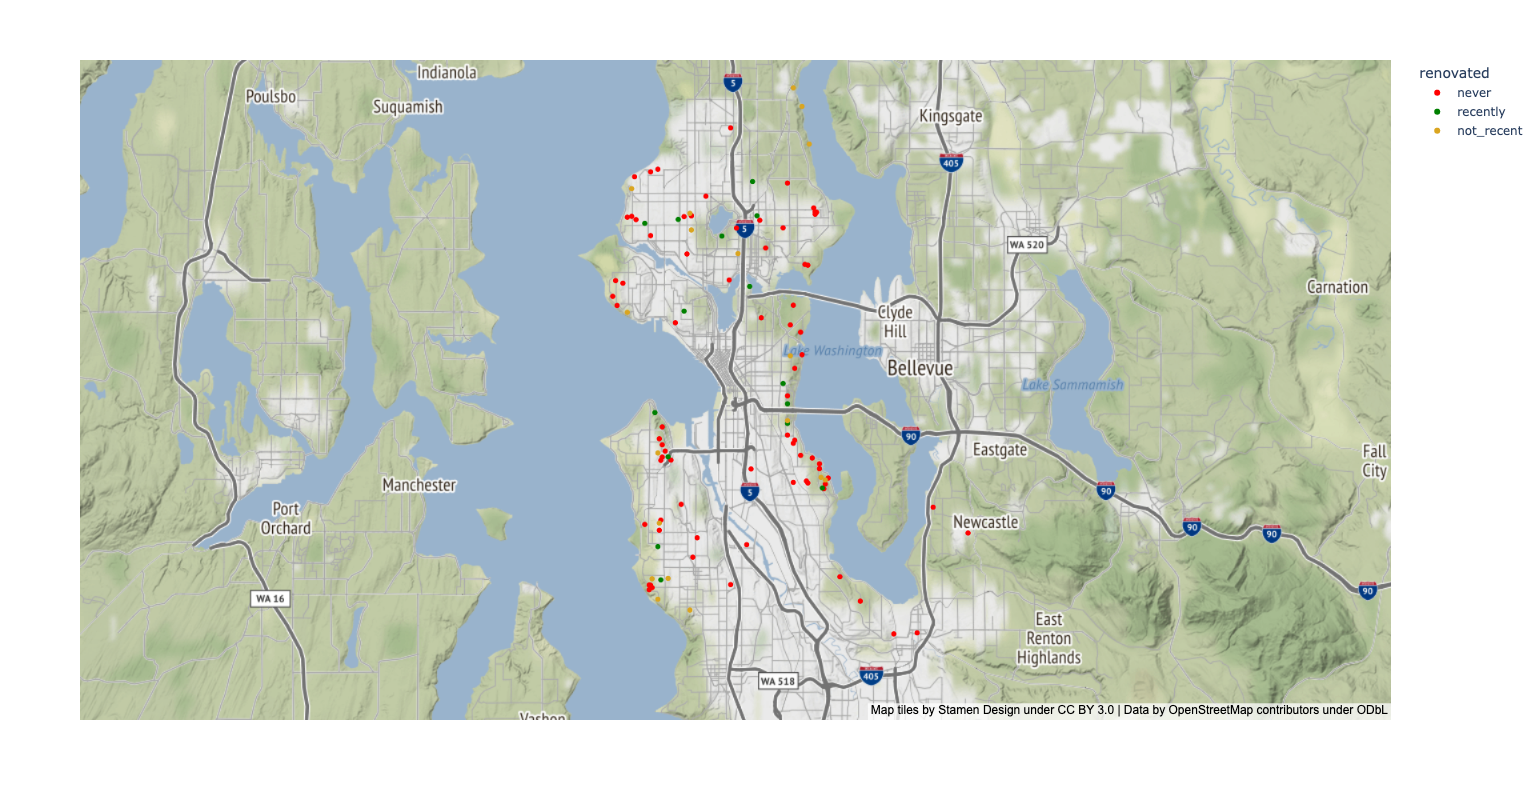

In [68]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin2"]>50]), lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "renovated", color_discrete_map={
                "recently": "green",
                "not_recent": "goldenrod",
                "never": "red"})
locations.show()

(-0.2, 3.5)

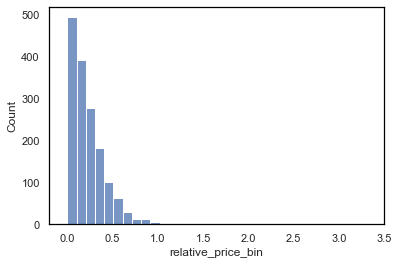

In [31]:
old(df[df["relative_price_bin"]>0]).sort_values("relative_price_bin",ascending=False)
sns.histplot(data= old(df[df["relative_price_bin"]>0]), x="relative_price_bin", bins=20)
plt.xlim(-0.2,3.5)

(-0.2, 3.5)

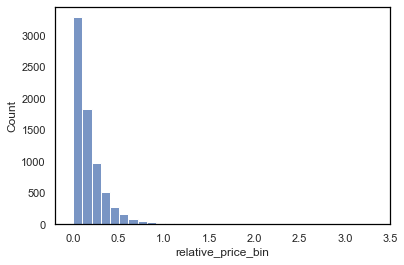

In [32]:
old(df[df["relative_price_bin"]>0]).sort_values("relative_price_bin",ascending=False)
sns.histplot(data= new(df[df["relative_price_bin"]>0]), x="relative_price_bin", bins=30)
plt.xlim(-0.2,3.5)

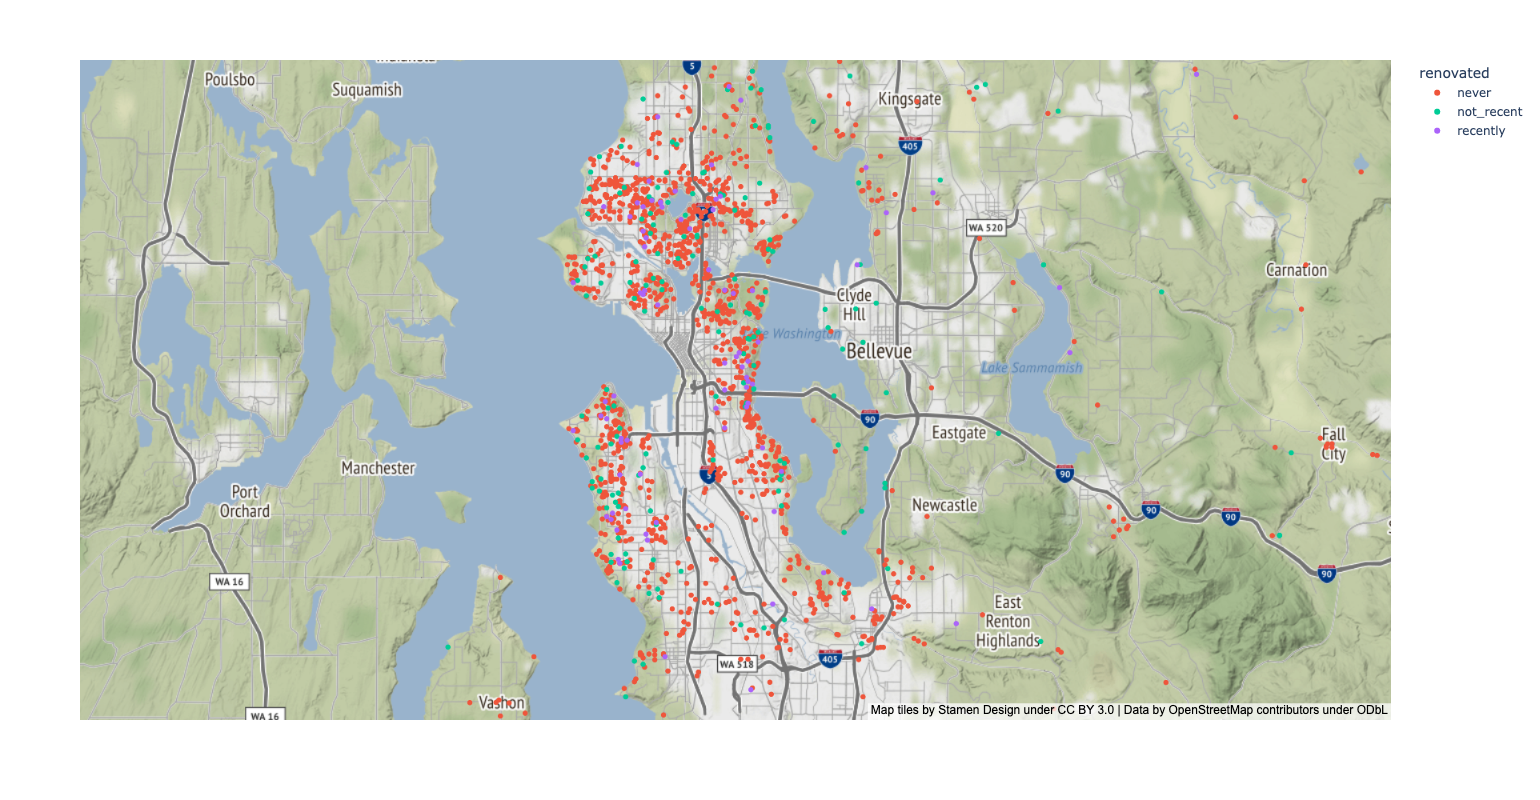

In [33]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"]>=0]), lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "renovated", color_continuous_scale=px.colors.sequential.Rainbow)
locations.show()

In [34]:
old(df).relative_price_bin

2       -0.180
11      -0.093
12       0.000
14      -0.138
17      -0.171
         ...  
21027   -0.200
21224   -0.249
21316   -0.564
21454   -0.104
21567   -0.004
Name: relative_price_bin, Length: 4022, dtype: float64

In [35]:
a = old(df[df["relative_price_bin"] > 1]).mean()
b= old(df[df["relative_price_bin"] < 1]).mean()
c= pd.concat([a,b], axis = 1, copy=False, keys=("good","bad"))
c= c.transpose()
c

id       price  bedrooms  bathrooms  sqft_living   sqft_lot  \
good 5150007395.200 1092100.000     3.500      2.400     2531.300 172982.900   
bad  4659040518.388  565008.079     3.083      1.655     1703.449   9360.502   

      floors  waterfront  view  condition  ...  price_of_same_size_and_loc  \
good   1.800       0.125 2.300      3.100  ...                  502087.255   
bad    1.348       0.012 0.288      3.673  ...                  566478.699   

      neighborhood_price_win  relative_price_win  relative_price_bin  \
good              482240.699               1.284               1.212   
bad               569458.171              -0.024              -0.003   

      relative_size  yr_since_reno  big_sales_per_month  bad_sales_per_month  \
good          1.269         30.375              135.600                  NaN   
bad           1.030         81.959              148.938              161.850   

      monthly_sales  monthly sales  
good       1829.300       1829.300  
bad        1909.857       1909.857  

[2 rows x 30 columns]

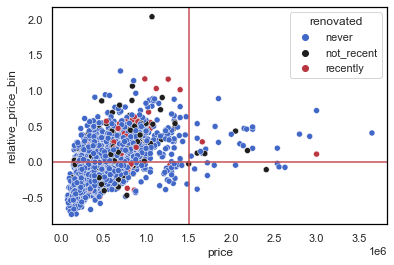

In [37]:
sns.scatterplot(data= old(df[df["relative_price_bin"] != 0]),x="price",y="relative_price_bin", hue="renovated", palette="icefire")
plt.axhline(0, color="r")
plt.axvline(1.5e6, color="r")

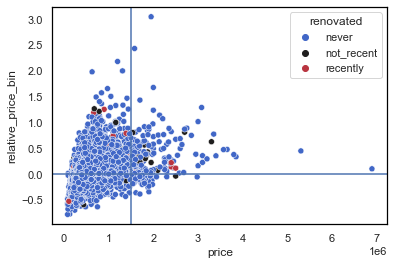

In [38]:
sns.scatterplot(data= new(df[df["relative_price_bin"] != 0]),x="price",y="relative_price_bin", hue="renovated", palette="icefire")
plt.axhline(0)
plt.axvline(1.5e6)

In [39]:
old(df[df["relative_price_bin"] < 1]).mean()

id                           4659040518.388
price                            565008.079
bedrooms                              3.083
bathrooms                             1.655
sqft_living                        1703.449
sqft_lot                           9360.502
floors                                1.348
waterfront                            0.012
view                                  0.288
condition                             3.673
grade                                 6.975
sqft_above                         1386.705
yr_built                           1924.549
yr_renovated                        202.415
zipcode                           98114.527
lat                                  47.599
long                               -122.310
sqft_living15                      1668.898
sqft_lot15                         7619.729
month                                 6.623
price_of_same_size_and_loc       566478.699
neighborhood_price_win           569458.171
relative_price_win              

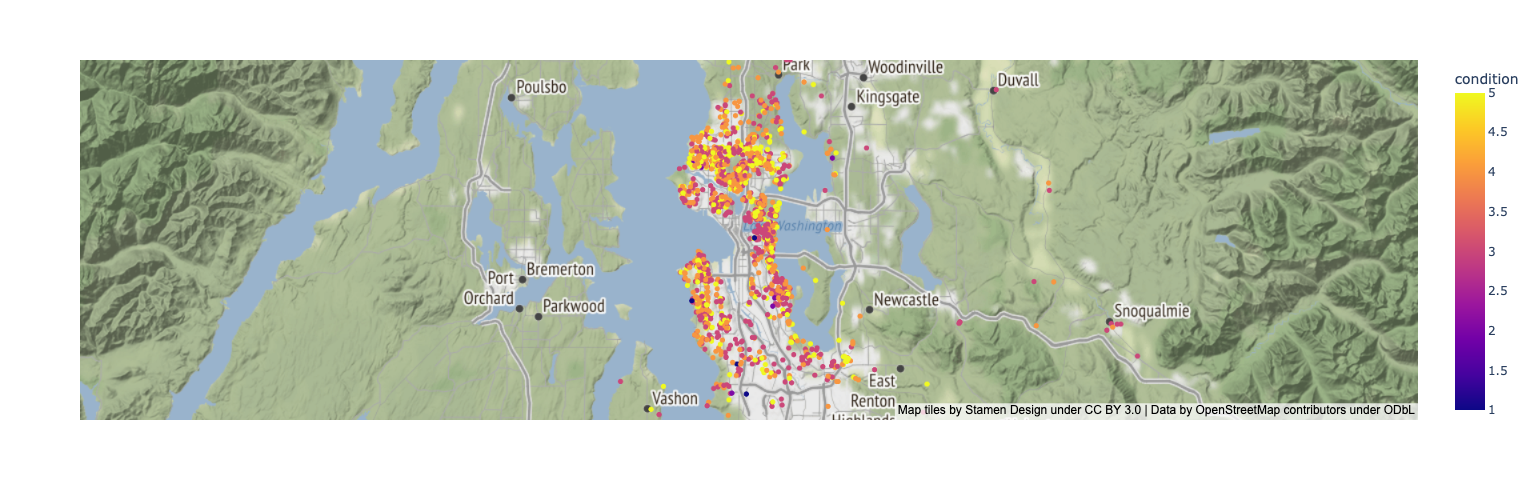

In [43]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"] > 0]), lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =9,  width = 800, height=500, color = "condition")
locations.show()

In [ ]:
locations = px.scatter_mapbox(df, lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =9,  width = 800, height=500, color = "relative_price_bin", color_continuous_scale=px.colors.diverging.RdBu)
locations.show()

# 4. Plot - How big are the most lucrative old houses?

In [ ]:
sns.barplot(data=old(df), x="sqft_living_bin", y="relative_price_win", hue="renovated", palette = "pastel", ci= None)
plt.axhline(0, alpha=0.5)

In [ ]:
sns.scatterplot(data=old(df), x="relative_size", y="relative_price_bin", hue="bathrooms")
plt.axhline(0)
plt.axvline(1)
plt.xlim(0,6.3)
plt.ylim(-1.2,10)

In [ ]:
sns.scatterplot(data=new(df), x="relative_size", y="relative_price_win", hue="bathrooms", palette="icefire")
plt.axhline(0)
plt.axvline(1)
plt.xlim(0,6.3)
plt.ylim(-1.2,10)

# Recommendations:
## 1. Renovate houses before selling / Buy unrenovated
    - recent renovations (<10 years) increase resale value of historicals more
    - bad condition reduces price of historicals much more
## 2. Sell in April
    - Relative selling price largest in April, especially for old houses
    - Month with highest number of sales over market value
    - Seemingly people are more inclined to spend more than marketvalue after winter?
    
## 3. Most lucrative buildings at waterfront
    - No surprise here
## 4. Invest in Large/Small houses